In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from pprint import pprint
from math import ceil
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
print("TF version : ", tf.__version__)
print("Keras version : ", keras.__version__)
with_cuda = tf.test.is_built_with_cuda()
with_gpu = tf.test.is_gpu_available()
print("Built with CUDA : ", with_cuda)
print("Available GPU : ", with_gpu)

if with_cuda and with_gpu:
    keras.backend.set_image_data_format('channels_first')
else: 
    keras.backend.set_image_data_format('channels_last')

print("keras data_format : ", keras.backend.image_data_format())

TF version :  1.10.0
Keras version :  2.1.6-tf
Built with CUDA :  True
Available GPU :  True
keras data_format :  channels_first


In [4]:
BATCH_SIZE = 128
EPOCHS = 200
INIT_LR = 0.1

In [5]:
print("... loading CIFAR10 dataset ...")
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

x_train, y_train = shuffle(x_train, y_train, random_state=51)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2,
                                                  stratify=y_train,
                                                  random_state=51)
# cast samples and labels
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = keras.utils.to_categorical(y_train.astype(np.int32), num_classes=10)
y_val = keras.utils.to_categorical(y_val.astype(np.int32), num_classes=10)
y_test = keras.utils.to_categorical(y_test.astype(np.int32), num_classes=10)

print("\tTRAIN - images {} | {}  - labels {} - {}".format(x_train.shape, x_train.dtype, y_train.shape, y_train.dtype))
print("\tVAL - images {} | {}  - labels {} - {}".format(x_val.shape, x_val.dtype, y_val.shape, y_val.dtype))
print("\tTEST - images {} | {}  - labels {} - {}\n".format(x_test.shape, x_test.dtype, y_test.shape, y_test.dtype))

... loading CIFAR10 dataset ...
	TRAIN - images (40000, 3, 32, 32) | float32  - labels (40000, 10) - float32
	VAL - images (10000, 3, 32, 32) | float32  - labels (10000, 10) - float32
	TEST - images (10000, 3, 32, 32) | float32  - labels (10000, 10) - float32



In [6]:
generator_aug = keras.preprocessing.image.ImageDataGenerator(samplewise_center=True,
                                                             samplewise_std_normalization=True,
                                                             width_shift_range=5,
                                                             height_shift_range=5,
                                                             fill_mode='constant',
                                                             cval=0.0,
                                                             horizontal_flip=True,
                                                             vertical_flip=False,
                                                             data_format=keras.backend.image_data_format())

generator = keras.preprocessing.image.ImageDataGenerator(samplewise_center=True,
                                                         samplewise_std_normalization=True,
                                                         data_format=keras.backend.image_data_format())

# python iterator object that yields augmented samples 
iterator_train_aug = generator_aug.flow(x_train, y_train, batch_size=BATCH_SIZE)

# python iterators object that yields not augmented samples 
iterator_train = generator.flow(x_train, y_train, batch_size=BATCH_SIZE)
iterator_valid = generator.flow(x_val, y_val, batch_size=BATCH_SIZE)
iterator_test = generator.flow(x_test, y_test, batch_size=BATCH_SIZE)

steps_per_epoch_train = int(ceil(iterator_train.n/BATCH_SIZE))
steps_per_epoch_val = int(ceil(iterator_valid.n/BATCH_SIZE))
steps_per_epoch_test = int(ceil(iterator_test.n/BATCH_SIZE))

In [7]:
# test iterator with data augmentation
x, y = iterator_train_aug.next()

print("x : {} | {}".format(x.shape, x.dtype))
print("y : {} | {}".format(y.shape, y.dtype))

x : (128, 3, 32, 32) | float32
y : (128, 10) | float32


# Build Keras model

In [8]:
from resnet import ResNet56

In [9]:
shape = [3, 32, 32] if keras.backend.image_data_format()=='channels_first' else [32, 32, 3]

model = ResNet56(input_shape=shape, classes=10, a=3, b=8, activation='randomized-relu').build_model()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 32, 32)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 30, 30)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 30, 30)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
randomized_re_lu_keras (Randomi (None, 16, 30, 30)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
optimizer = keras.optimizers.SGD(lr=INIT_LR, momentum=0.9)
loss = 'categorical_crossentropy'
metrics = ['acc', ]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
# model.save_weights('random_weights.h5')
model.load_weights('random_weights.h5')

# Train model

In [13]:
callbacks = []

model_ckpt = keras.callbacks.ModelCheckpoint("model_ckpt_dropactivation_best_randomized-relu.h5",
                                             monitor='val_acc', verbose=1, save_best_only=True, 
                                             save_weights_only=True)
callbacks.append(model_ckpt)

def schedule(epoch):
    if epoch < 91:
        return INIT_LR
    if epoch < 136:
        return 0.1*INIT_LR
    if epoch < 182:
        return 0.01*INIT_LR
    else:
        return 0.001*INIT_LR
    
lr_schedule = keras.callbacks.LearningRateScheduler(schedule, verbose=1)
callbacks.append(lr_schedule)

In [14]:
%%time

history = model.fit_generator(iterator_train_aug, 
                              steps_per_epoch=steps_per_epoch_train,
                              epochs=EPOCHS,
                              verbose=1,
                              validation_data=iterator_valid,
                              validation_steps=steps_per_epoch_val,
                              callbacks=callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/200
312/313 [============================>.] - ETA: 0s - loss: 2.4023 - acc: 0.3980
Epoch 00001: val_acc improved from -inf to 0.24990, saving model to model_ckpt_dropactivation_best_randomized-relu.h5
313/313 [==============================] - 55s 174ms/step - loss: 2.4011 - acc: 0.3984 - val_loss: 4.5791 - val_acc: 0.2499

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/200
312/313 [============================>.] - ETA: 0s - loss: 1.8578 - acc: 0.5607
Epoch 00002: val_acc improved from 0.24990 to 0.46660, saving model to model_ckpt_dropactivation_best_randomized-relu.h5
313/313 [==============================] - 34s 107ms/step - loss: 1.8577 - acc: 0.5607 - val_loss: 2.1057 - val_acc: 0.4666

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
Epoch 3/200
312/313 [============================>.] - ETA: 0s - loss: 1.6052 - acc: 0.6172- ETA: 2s - loss: 1
Epoch 00003: val_

312/313 [============================>.] - ETA: 0s - loss: 0.7553 - acc: 0.8199- ETA: 1s - loss: 0.7537
Epoch 00023: val_acc did not improve from 0.75140
313/313 [==============================] - 33s 106ms/step - loss: 0.7553 - acc: 0.8199 - val_loss: 1.2459 - val_acc: 0.6588

Epoch 00024: LearningRateScheduler reducing learning rate to 0.1.
Epoch 24/200
312/313 [============================>.] - ETA: 0s - loss: 0.7516 - acc: 0.8211
Epoch 00024: val_acc did not improve from 0.75140
313/313 [==============================] - 33s 106ms/step - loss: 0.7516 - acc: 0.8210 - val_loss: 1.1807 - val_acc: 0.6749

Epoch 00025: LearningRateScheduler reducing learning rate to 0.1.
Epoch 25/200
312/313 [============================>.] - ETA: 0s - loss: 0.7466 - acc: 0.8222
Epoch 00025: val_acc did not improve from 0.75140
313/313 [==============================] - 33s 106ms/step - loss: 0.7469 - acc: 0.8221 - val_loss: 0.9788 - val_acc: 0.7439

Epoch 00026: LearningRateScheduler reducing learning 

312/313 [============================>.] - ETA: 0s - loss: 0.6991 - acc: 0.8467
Epoch 00047: val_acc did not improve from 0.79400
313/313 [==============================] - 33s 106ms/step - loss: 0.6989 - acc: 0.8466 - val_loss: 1.3093 - val_acc: 0.6423

Epoch 00048: LearningRateScheduler reducing learning rate to 0.1.
Epoch 48/200
312/313 [============================>.] - ETA: 0s - loss: 0.6971 - acc: 0.8478
Epoch 00048: val_acc did not improve from 0.79400
313/313 [==============================] - 33s 106ms/step - loss: 0.6969 - acc: 0.8479 - val_loss: 0.8855 - val_acc: 0.7940

Epoch 00049: LearningRateScheduler reducing learning rate to 0.1.
Epoch 49/200
312/313 [============================>.] - ETA: 0s - loss: 0.6893 - acc: 0.8497
Epoch 00049: val_acc did not improve from 0.79400
313/313 [==============================] - 33s 106ms/step - loss: 0.6893 - acc: 0.8498 - val_loss: 1.2230 - val_acc: 0.6830

Epoch 00050: LearningRateScheduler reducing learning rate to 0.1.
Epoch 50/20

312/313 [============================>.] - ETA: 0s - loss: 0.6656 - acc: 0.8631
Epoch 00071: val_acc improved from 0.80690 to 0.81500, saving model to model_ckpt_dropactivation_best_randomized-relu.h5
313/313 [==============================] - 34s 107ms/step - loss: 0.6654 - acc: 0.8631 - val_loss: 0.8220 - val_acc: 0.8150

Epoch 00072: LearningRateScheduler reducing learning rate to 0.1.
Epoch 72/200
312/313 [============================>.] - ETA: 0s - loss: 0.6660 - acc: 0.8625
Epoch 00072: val_acc did not improve from 0.81500
313/313 [==============================] - 33s 106ms/step - loss: 0.6662 - acc: 0.8624 - val_loss: 1.1099 - val_acc: 0.7114

Epoch 00073: LearningRateScheduler reducing learning rate to 0.1.
Epoch 73/200
312/313 [============================>.] - ETA: 0s - loss: 0.6693 - acc: 0.8605
Epoch 00073: val_acc did not improve from 0.81500
313/313 [==============================] - 33s 106ms/step - loss: 0.6690 - acc: 0.8605 - val_loss: 1.0574 - val_acc: 0.7345

Epoch 

313/313 [==============================] - 33s 106ms/step - loss: 0.4427 - acc: 0.9357 - val_loss: 0.6750 - val_acc: 0.8625

Epoch 00095: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 95/200
312/313 [============================>.] - ETA: 0s - loss: 0.4252 - acc: 0.9399
Epoch 00095: val_acc improved from 0.86250 to 0.87660, saving model to model_ckpt_dropactivation_best_randomized-relu.h5
313/313 [==============================] - 33s 107ms/step - loss: 0.4252 - acc: 0.9398 - val_loss: 0.6288 - val_acc: 0.8766

Epoch 00096: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 96/200
312/313 [============================>.] - ETA: 0s - loss: 0.4143 - acc: 0.9415
Epoch 00096: val_acc improved from 0.87660 to 0.88470, saving model to model_ckpt_dropactivation_best_randomized-relu.h5
313/313 [==============================] - 33s 106ms/step - loss: 0.4141 - acc: 0.9415 - val_loss: 0.6032 - val_acc: 0.8847

Epoch 00097: LearningRateSchedu

312/313 [============================>.] - ETA: 0s - loss: 0.2820 - acc: 0.9610
Epoch 00116: val_acc did not improve from 0.89390
313/313 [==============================] - 33s 105ms/step - loss: 0.2823 - acc: 0.9608 - val_loss: 0.5211 - val_acc: 0.8832

Epoch 00117: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 117/200
312/313 [============================>.] - ETA: 0s - loss: 0.2766 - acc: 0.9624
Epoch 00117: val_acc did not improve from 0.89390
313/313 [==============================] - 33s 105ms/step - loss: 0.2765 - acc: 0.9625 - val_loss: 0.4980 - val_acc: 0.8906

Epoch 00118: LearningRateScheduler reducing learning rate to 0.010000000000000002.
Epoch 118/200
312/313 [============================>.] - ETA: 0s - loss: 0.2753 - acc: 0.9622
Epoch 00118: val_acc did not improve from 0.89390
313/313 [==============================] - 33s 105ms/step - loss: 0.2752 - acc: 0.9622 - val_loss: 0.4838 - val_acc: 0.8916

Epoch 00119: LearningRateScheduler reduci

312/313 [============================>.] - ETA: 0s - loss: 0.1877 - acc: 0.9853
Epoch 00139: val_acc improved from 0.90150 to 0.90230, saving model to model_ckpt_dropactivation_best_randomized-relu.h5
313/313 [==============================] - 33s 106ms/step - loss: 0.1879 - acc: 0.9852 - val_loss: 0.4340 - val_acc: 0.9023

Epoch 00140: LearningRateScheduler reducing learning rate to 0.001.
Epoch 140/200
312/313 [============================>.] - ETA: 0s - loss: 0.1858 - acc: 0.9860
Epoch 00140: val_acc improved from 0.90230 to 0.90370, saving model to model_ckpt_dropactivation_best_randomized-relu.h5
313/313 [==============================] - 33s 106ms/step - loss: 0.1858 - acc: 0.9860 - val_loss: 0.4283 - val_acc: 0.9037

Epoch 00141: LearningRateScheduler reducing learning rate to 0.001.
Epoch 141/200
312/313 [============================>.] - ETA: 0s - loss: 0.1827 - acc: 0.9873
Epoch 00141: val_acc improved from 0.90370 to 0.90490, saving model to model_ckpt_dropactivation_best_ra

312/313 [============================>.] - ETA: 0s - loss: 0.1590 - acc: 0.9932
Epoch 00161: val_acc improved from 0.90810 to 0.91060, saving model to model_ckpt_dropactivation_best_randomized-relu.h5
313/313 [==============================] - 33s 107ms/step - loss: 0.1590 - acc: 0.9932 - val_loss: 0.4253 - val_acc: 0.9106

Epoch 00162: LearningRateScheduler reducing learning rate to 0.001.
Epoch 162/200
312/313 [============================>.] - ETA: 0s - loss: 0.1582 - acc: 0.9933
Epoch 00162: val_acc did not improve from 0.91060
313/313 [==============================] - 33s 105ms/step - loss: 0.1582 - acc: 0.9933 - val_loss: 0.4256 - val_acc: 0.9091

Epoch 00163: LearningRateScheduler reducing learning rate to 0.001.
Epoch 163/200
312/313 [============================>.] - ETA: 0s - loss: 0.1588 - acc: 0.9931
Epoch 00163: val_acc did not improve from 0.91060
313/313 [==============================] - 33s 105ms/step - loss: 0.1589 - acc: 0.9930 - val_loss: 0.4267 - val_acc: 0.9090



312/313 [============================>.] - ETA: 0s - loss: 0.1462 - acc: 0.9950
Epoch 00185: val_acc did not improve from 0.91180
313/313 [==============================] - 33s 105ms/step - loss: 0.1461 - acc: 0.9950 - val_loss: 0.4262 - val_acc: 0.9100

Epoch 00186: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 186/200
312/313 [============================>.] - ETA: 0s - loss: 0.1464 - acc: 0.9948
Epoch 00186: val_acc did not improve from 0.91180
313/313 [==============================] - 33s 105ms/step - loss: 0.1466 - acc: 0.9947 - val_loss: 0.4260 - val_acc: 0.9091

Epoch 00187: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 187/200
312/313 [============================>.] - ETA: 0s - loss: 0.1447 - acc: 0.9957
Epoch 00187: val_acc did not improve from 0.91180
313/313 [==============================] - 33s 105ms/step - loss: 0.1448 - acc: 0.9957 - val_loss: 0.4253 - val_acc: 0.9090

Epoch 00188: LearningRateScheduler reducing learning rate to 0.0001.


In [15]:
import pickle
with open('randomized-relu-history.dict', 'wb') as f:
    pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
hist_dict = history.history
print(list(hist_dict.keys()))

['val_loss', 'acc', 'loss', 'val_acc']


In [17]:
# load best model
model.load_weights('model_ckpt_dropactivation_best_randomized-relu.h5')

In [18]:
best_epoch = np.argmax(hist_dict['val_acc'])
print("best epoch : {}  |  {}".format(best_epoch, hist_dict['val_acc'][best_epoch]))

best epoch : 166  |  0.9118


In [19]:
loss_test, acc_test = model.evaluate_generator(generator=iterator_test, steps=steps_per_epoch_test, verbose=1)
print("ACC (test) : ", acc_test)
print("LOSS (test) : ", loss_test)

79/79 [==============================] - 2s 22ms/step
ACC (test) :  0.9065
LOSS (test) :  0.4296488745689392


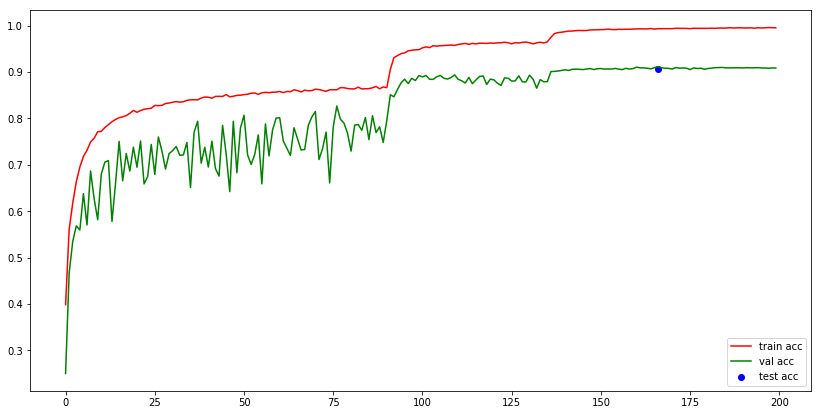

In [20]:
plt.figure(figsize=(14,7))
plt.plot(list(range(EPOCHS)), hist_dict['acc'], color='red', label='train acc')
plt.plot(list(range(EPOCHS)), hist_dict['val_acc'], color='green', label='val acc')
plt.scatter([best_epoch, ], [acc_test, ], color='blue', label='test acc')
plt.legend(loc='lower right')

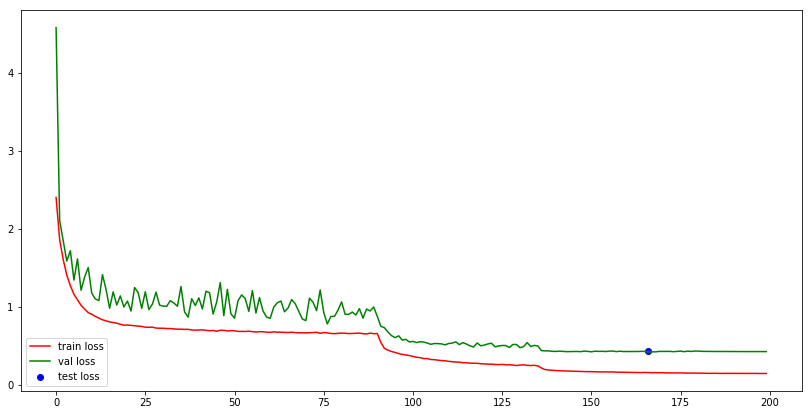

In [21]:
plt.figure(figsize=(14,7))
plt.plot(list(range(EPOCHS)), hist_dict['loss'], color='red', label='train loss')
plt.plot(list(range(EPOCHS)), hist_dict['val_loss'], color='green', label='val loss')
plt.scatter([best_epoch, ], [loss_test, ], color='blue', label='test loss')
plt.legend(loc='lower left')